In [2]:
pip install ultralytics

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import os
import yaml
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image
from ultralytics import YOLO
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.ops import MultiScaleRoIAlign
from torchvision.transforms import functional as FT
from torch.utils.data import DataLoader, Dataset


In [ ]:
# KITTI dataset paths (remain the same)
KITTI_BASE_DIR = '/kaggle/input/kitti-dataset'
IMAGE_DIR = Path(KITTI_BASE_DIR) / 'data_object_image_2' / 'training' / 'image_2'
LABEL_DIR = Path(KITTI_BASE_DIR) / 'data_object_label_2' / 'training' / 'label_2'
TRAIN_DIR = Path('train')
VALID_DIR = Path('valid')
LABELS_DIR = Path('labels_with_dont_care')

CLASSES = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']
CLAZZ_NUMBERS = {name: idx for idx, name in enumerate(CLASSES)}
IMG_SIZE = 640
BATCH_SIZE = 16
EPOCHS = 25
MODEL_PATH = 'hybrid_yolo_frcnn.h5'

# Ensure directories exist
for folder in [TRAIN_DIR, VALID_DIR, LABELS_DIR]:
    folder.mkdir(exist_ok=True)

# Rest of the helper functions remain the same
def convert_bbox_to_yolo(bbox, size):
    dw, dh = 1.0 / size[0], 1.0 / size[1]
    x_center, y_center = (bbox[0] + bbox[1]) / 2.0, (bbox[2] + bbox[3]) / 2.0
    width, height = bbox[1] - bbox[0], bbox[3] - bbox[2]
    return x_center * dw, y_center * dh, width * dw, height * dh

def parse_kitti_label_file(lbl_path, img_path):
    with open(lbl_path, 'r', encoding='utf-8') as file:
        lines = file.read().strip().split('\n')
    yolo_labels = []
    img_size = Image.open(img_path).size  # (width, height)
    for line in lines:
        parts = line.split()
        if parts[0] not in CLAZZ_NUMBERS:
            continue
        bbox = (float(parts[4]), float(parts[6]), float(parts[5]), float(parts[7]))
        yolo_labels.append((CLAZZ_NUMBERS[parts[0]], *convert_bbox_to_yolo(bbox, img_size)))
    return yolo_labels

# Dataset preparation (remain the same)
image_paths = sorted(IMAGE_DIR.glob('*.png'))
label_paths = sorted(LABEL_DIR.glob('*.txt'))

for img_path in image_paths:
    lbl_path = LABEL_DIR / f"{img_path.stem}.txt"
    if lbl_path.exists():
        yolo_labels = parse_kitti_label_file(lbl_path, img_path)
        with open(LABELS_DIR / f"{img_path.stem}.txt", 'w') as lf:
            for lbl in yolo_labels:
                lf.write(" ".join(f"{val:.6f}" for val in lbl) + "\n")

labels_for_images = [(img, LABELS_DIR / f"{img.stem}.txt") for img in image_paths if (LABELS_DIR / f"{img.stem}.txt").exists()]
train_pairs, valid_pairs = train_test_split(labels_for_images, test_size=0.1, random_state=42, shuffle=True)

for folder in [TRAIN_DIR, VALID_DIR]:
    for sub in ['images', 'labels']:
        (folder / sub).mkdir(exist_ok=True)

for img_path, lbl_path in train_pairs:
    shutil.copy(img_path, TRAIN_DIR / 'images' / img_path.name)
    shutil.copy(lbl_path, TRAIN_DIR / 'labels' / lbl_path.name)
for img_path, lbl_path in valid_pairs:
    shutil.copy(img_path, VALID_DIR / 'images' / img_path.name)
    shutil.copy(lbl_path, VALID_DIR / 'labels' / lbl_path.name)

data_config = {'train': str((TRAIN_DIR / 'images').resolve()), 'val': str((VALID_DIR / 'images').resolve()), 'names': CLASSES, 'nc': len(CLASSES)}
with open('data.yaml', 'w') as f:
    yaml.dump(data_config, f)

In [17]:
class ImageList(object):
    """
    Structure that holds a list of images (of possibly varying sizes) as a single tensor.
    This works by padding the images to the same size.
    """
    def __init__(self, tensors, image_sizes):
        self.tensors = tensors
        self.image_sizes = image_sizes

    def to(self, device):
        cast_tensor = self.tensors.to(device)
        return ImageList(cast_tensor, self.image_sizes)

class FasterRCNNScratch(nn.Module):
    def __init__(self, num_classes):
        super(FasterRCNNScratch, self).__init__()
        
        # Backbone with FPN
        self.backbone = resnet_fpn_backbone('resnet50', pretrained=True)
        out_channels = self.backbone.out_channels
        
        # RPN parameters
        anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
        aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
        rpn_anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)
        rpn_head = RPNHead(out_channels, rpn_anchor_generator.num_anchors_per_location()[0])
        
        # RPN parameters
        rpn_pre_nms_top_n = dict(training=2000, testing=1000)
        rpn_post_nms_top_n = dict(training=2000, testing=1000)
        
        # Corrected RPN initialization with proper number of arguments
        self.rpn = RegionProposalNetwork(
            rpn_anchor_generator,
            rpn_head,
            0.7,  # fg_iou_thresh
            0.3,  # bg_iou_thresh
            256,  # batch_size_per_image
            0.5,  # positive_fraction
            rpn_pre_nms_top_n,
            rpn_post_nms_top_n,
            0.7)  # nms_thresh
        
        # ROI Heads parameters
        box_roi_pool = MultiScaleRoIAlign(
            featmap_names=['0', '1', '2', '3'],
            output_size=7,
            sampling_ratio=2)
        
        resolution = box_roi_pool.output_size[0]
        representation_size = 1024
        box_head = TwoMLPHead(
            out_channels * resolution ** 2,
            representation_size)
        
        box_predictor = FastRCNNPredictor(
            representation_size,
            num_classes)
        
        # ROI Heads parameters
        box_score_thresh = 0.05
        box_nms_thresh = 0.5
        box_detections_per_img = 100
        box_fg_iou_thresh = 0.5
        box_bg_iou_thresh = 0.5
        box_batch_size_per_image = 512
        box_positive_fraction = 0.25
        bbox_reg_weights = None
        
        # ROI Heads
        self.roi_heads = RoIHeads(
            box_roi_pool, box_head, box_predictor,
            box_fg_iou_thresh, box_bg_iou_thresh,
            box_batch_size_per_image, box_positive_fraction,
            bbox_reg_weights,
            box_score_thresh, box_nms_thresh, box_detections_per_img)
        
        # Transform
        min_size = 800
        max_size = 1333
        image_mean = [0.485, 0.456, 0.406]
        image_std = [0.229, 0.224, 0.225]
        self.transform = GeneralizedRCNNTransform(min_size, max_size, image_mean, image_std)
    
    def forward(self, images, targets=None):
        """
        Args:
            images (list[Tensor]): images to be processed
            targets (list[Dict[Tensor]]): ground-truth boxes present in the image
        """
        if self.training and targets is None:
            raise ValueError("In training mode, targets should be passed")
        
        original_image_sizes = []
        for img in images:
            val = img.shape[-2:]
            original_image_sizes.append((val[0], val[1]))
        
        # Transform images
        images, targets = self.transform(images, targets)
        
        # Get features from backbone
        features = self.backbone(images.tensors)
        
        # Get proposals from RPN
        proposals, proposal_losses = self.rpn(images, features, targets)
        
        # Get detections from ROI Heads
        detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets)
        
        # Format output
        detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)
        
        losses = {}
        losses.update(proposal_losses)
        losses.update(detector_losses)
        
        if self.training:
            return losses
        
        return detections

def load_faster_rcnn(num_classes=9):
    return FasterRCNNScratch(num_classes=num_classes)
    

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import misc as misc_nn_ops
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection import _utils as det_utils
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection.rpn import RPNHead, RegionProposalNetwork
from torchvision.models.detection.roi_heads import RoIHeads
from torchvision.models.detection.faster_rcnn import TwoMLPHead, FastRCNNPredictor
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

In [11]:
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import os
import yaml
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image
from ultralytics import YOLO
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.ops import MultiScaleRoIAlign
from torchvision.transforms import functional as FT
from torch.utils.data import DataLoader, Dataset

# Building Faster R-CNN from scratch
class FasterRCNNFromScratch(nn.Module):
    def __init__(self, num_classes=9):
        super(FasterRCNNFromScratch, self).__init__()
        
        # Backbone with FPN
        self.backbone = resnet_fpn_backbone('resnet50', pretrained=True)
        
        # Anchor generator
        anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
        aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
        self.anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)
        
        # RPN Head
        out_channels = self.backbone.out_channels
        self.rpn_head = RPNHead(out_channels, self.anchor_generator.num_anchors_per_location()[0])
        
        # ROI Pooling
        self.roi_pooler = MultiScaleRoIAlign(
            featmap_names=['0', '1', '2', '3'],
            output_size=7,
            sampling_ratio=2)
        
        # Box Head
        resolution = self.roi_pooler.output_size[0]
        representation_size = 1024
        self.box_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(out_channels * resolution ** 2, representation_size),
            nn.ReLU(inplace=True))
        
        # Box Predictor
        self.box_predictor = FastRCNNPredictor(representation_size, num_classes)
        
    def forward(self, images, targets=None):
        # Get features from backbone
        features = self.backbone(images.tensors if isinstance(images, ImageList) else images)
        
        # Generate proposals from RPN
        proposals, proposal_losses = self.rpn(images, features, targets)
        
        # ROI Pooling and box head
        box_features = self.roi_pooler(features, proposals, images.image_sizes)
        box_features = self.box_head(box_features)
        
        # Class predictions and box regression
        class_logits, box_regression = self.box_predictor(box_features)
        
        # Format output
        result = []
        losses = {}
        if self.training:
            losses.update(proposal_losses)
            # Add box classification and regression losses here
        else:
            boxes, scores, labels = self.postprocess_detections(class_logits, box_regression, proposals, images.image_sizes)
            result = [{'boxes': boxes[i], 'labels': labels[i], 'scores': scores[i]} for i in range(len(boxes))]
        
        return result if not self.training else losses

def load_faster_rcnn(num_classes=9):
    return FasterRCNNFromScratch(num_classes=num_classes)

# KITTI dataset paths (remain the same)
KITTI_BASE_DIR = '/kaggle/input/kitti-dataset'
IMAGE_DIR = Path(KITTI_BASE_DIR) / 'data_object_image_2' / 'training' / 'image_2'
LABEL_DIR = Path(KITTI_BASE_DIR) / 'data_object_label_2' / 'training' / 'label_2'
TRAIN_DIR = Path('train')
VALID_DIR = Path('valid')
LABELS_DIR = Path('labels_with_dont_care')

CLASSES = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']
CLAZZ_NUMBERS = {name: idx for idx, name in enumerate(CLASSES)}
IMG_SIZE = 640
BATCH_SIZE = 16
EPOCHS = 25
MODEL_PATH = 'hybrid_yolo_frcnn.h5'

# Ensure directories exist
for folder in [TRAIN_DIR, VALID_DIR, LABELS_DIR]:
    folder.mkdir(exist_ok=True)

# Rest of the helper functions remain the same
def convert_bbox_to_yolo(bbox, size):
    dw, dh = 1.0 / size[0], 1.0 / size[1]
    x_center, y_center = (bbox[0] + bbox[1]) / 2.0, (bbox[2] + bbox[3]) / 2.0
    width, height = bbox[1] - bbox[0], bbox[3] - bbox[2]
    return x_center * dw, y_center * dh, width * dw, height * dh

def parse_kitti_label_file(lbl_path, img_path):
    with open(lbl_path, 'r', encoding='utf-8') as file:
        lines = file.read().strip().split('\n')
    yolo_labels = []
    img_size = Image.open(img_path).size  # (width, height)
    for line in lines:
        parts = line.split()
        if parts[0] not in CLAZZ_NUMBERS:
            continue
        bbox = (float(parts[4]), float(parts[6]), float(parts[5]), float(parts[7]))
        yolo_labels.append((CLAZZ_NUMBERS[parts[0]], *convert_bbox_to_yolo(bbox, img_size)))
    return yolo_labels

# Dataset preparation (remain the same)
image_paths = sorted(IMAGE_DIR.glob('*.png'))
label_paths = sorted(LABEL_DIR.glob('*.txt'))

for img_path in image_paths:
    lbl_path = LABEL_DIR / f"{img_path.stem}.txt"
    if lbl_path.exists():
        yolo_labels = parse_kitti_label_file(lbl_path, img_path)
        with open(LABELS_DIR / f"{img_path.stem}.txt", 'w') as lf:
            for lbl in yolo_labels:
                lf.write(" ".join(f"{val:.6f}" for val in lbl) + "\n")

labels_for_images = [(img, LABELS_DIR / f"{img.stem}.txt") for img in image_paths if (LABELS_DIR / f"{img.stem}.txt").exists()]
train_pairs, valid_pairs = train_test_split(labels_for_images, test_size=0.1, random_state=42, shuffle=True)

for folder in [TRAIN_DIR, VALID_DIR]:
    for sub in ['images', 'labels']:
        (folder / sub).mkdir(exist_ok=True)

for img_path, lbl_path in train_pairs:
    shutil.copy(img_path, TRAIN_DIR / 'images' / img_path.name)
    shutil.copy(lbl_path, TRAIN_DIR / 'labels' / lbl_path.name)
for img_path, lbl_path in valid_pairs:
    shutil.copy(img_path, VALID_DIR / 'images' / img_path.name)
    shutil.copy(lbl_path, VALID_DIR / 'labels' / lbl_path.name)

data_config = {'train': str((TRAIN_DIR / 'images').resolve()), 'val': str((VALID_DIR / 'images').resolve()), 'names': CLASSES, 'nc': len(CLASSES)}
with open('data.yaml', 'w') as f:
    yaml.dump(data_config, f)

# Dataset class (remain the same)
class KITTIDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.label_filenames = sorted(os.listdir(label_dir))
        self.CLASS_MAPPING = {
            "Pedestrian": 1,
            "Car": 2,
            "Cyclist": 3,
            "Truck": 4,
            "Van": 5,
            "Tram": 6,
            "Misc": 7,
            "Person_sitting": 8
        }

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(image_path).convert("RGB")

        label_path = os.path.join(self.label_dir, self.label_filenames[idx])
        boxes = []
        labels = []

        with open(label_path, "r") as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()

                class_name = parts[0]  # Class is a string (e.g., "Pedestrian")
                if class_name not in self.CLASS_MAPPING:
                    continue

                class_label = self.CLASS_MAPPING[class_name]  # Convert to index
                x_min, y_min, x_max, y_max = map(float, parts[4:8])  # Use correct indices

                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(class_label)

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transform:
            image = self.transform(image)

        return image, target

def collate_fn(batch):
    images, targets = zip(*batch)  # Unzip batch
    return list(images), list(targets)  # Convert to lists

# Training functions (modified to use our custom Faster R-CNN)
def train_yolo():
    yolo_model = YOLO("yolov10n.pt")
    yolo_model.train(data="data.yaml", epochs=25, batch=16, imgsz=640)
    yolo_model.save("trained_yolov10.pt")

def train_faster_rcnn(dataloader):
    # Initialize our custom Faster R-CNN
    model = load_faster_rcnn(num_classes=9)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Define optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
    
    model.train()
    
    for batch_idx, batch in enumerate(dataloader):
        images, targets = batch  # Unpack batch
        
        print(f"Batch {batch_idx}: {len(images)} images, {len(targets)} targets")
        
        if len(images) == 0 or len(targets) == 0:
            continue  # Skip empty batches

        processed_images = []
        for i, img in enumerate(images):
            if isinstance(img, Image.Image):  # If image is PIL
                img = FT.to_tensor(img)  # Convert to tensor
            processed_images.append(img.to(device))  # Move to GPU/CPU

        # Process targets
        processed_targets = []
        for j, t in enumerate(targets):
            if not isinstance(t, dict):
                continue
            processed_targets.append({k: v.to(device) for k, v in t.items()})
            
        if len(processed_images) == 0 or len(processed_targets) == 0:
            continue  # Skip if empty after processing
        
        optimizer.zero_grad()

        # Forward pass with our custom model
        loss_dict = model(processed_images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()
        
    # Save final trained model
    torch.save(model.state_dict(), "trained_faster_rcnn.pth")
    print("Training step completed successfully!")

# Detection functions (remain the same)
def detect_with_faster_rcnn(image, model):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])
    
    img_tensor = transform(image).unsqueeze(0)  # Convert to tensor and add batch dimension
    model.eval()
    
    with torch.no_grad():
        outputs = model(img_tensor)

    return outputs

def detect_with_yolo(image_path, yolo_model):
    results = yolo_model(image_path)
    return results[0].boxes.data.cpu().numpy()

def compute_iou(box1, box2):
    # Implementation of IoU calculation
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    return inter_area / (box1_area + box2_area - inter_area)

def merge_detections(yolo_detections, frcnn_detections, iou_threshold=0.5):
    final_detections = []
    for yolo_det in yolo_detections:
        best_match = None
        best_iou = 0
        for frcnn_det in frcnn_detections[0]['boxes']:
            iou = compute_iou(yolo_det[:4], frcnn_det.cpu().numpy())
            if iou > best_iou:
                best_iou = iou
                best_match = frcnn_det
        if best_iou < iou_threshold:
            final_detections.append(yolo_det)
    for frcnn_det in frcnn_detections[0]['boxes']:
        final_detections.append(frcnn_det.cpu().numpy())
    return np.array(final_detections)

def detect_pedestrians(image_path, yolo_model, frcnn_model):
    image = Image.open(image_path).convert("RGB")
    yolo_detections = detect_with_yolo(image_path, yolo_model)
    frcnn_detections = detect_with_faster_rcnn(image, frcnn_model)
    return merge_detections(yolo_detections, frcnn_detections)

def save_hybrid_model(yolo_model, frcnn_model):
    hybrid_model = {
        'yolo': yolo_model.model.state_dict(),
        'frcnn': frcnn_model.state_dict()
    }
    torch.save(hybrid_model, MODEL_PATH)

# Main execution
if __name__ == "__main__":
    # Initialize dataset and dataloader

    train_faster_rcnn(train_loader)  # Train our custom Faster R-CNN
    
    # Load trained models
    yolo_model = YOLO("trained_yolov10.pt")
    frcnn_model = load_faster_rcnn(num_classes=9)
    frcnn_model.load_state_dict(torch.load("trained_faster_rcnn.pth"))
    
    # Save hybrid model
    save_hybrid_model(yolo_model, frcnn_model)

Ultralytics 8.3.99 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tr

train: Scanning /kaggle/working/train/labels... 6732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6732/6732 [00:41<00:00, 164.11it/s]


train: New cache created: /kaggle/working/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/valid/labels... 749 images, 0 backgrounds, 0 corrupt: 100%|██████████| 749/749 [00:04<00:00, 166.02it/s]


val: New cache created: /kaggle/working/valid/labels.cache
Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train4
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      5.08G      3.297      4.917      2.194        212        640: 100%|██████████| 421/421 [01:59<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.17it/s]


                   all        749       5425      0.401      0.281      0.236      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      5.08G      3.081      3.366       2.16        162        640: 100%|██████████| 421/421 [01:53<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.77it/s]


                   all        749       5425      0.426      0.327      0.277      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      5.08G      3.027      2.853      2.148        140        640: 100%|██████████| 421/421 [01:51<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.16it/s]


                   all        749       5425      0.363      0.377      0.341      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      5.08G      2.972      2.596      2.136        146        640: 100%|██████████| 421/421 [01:52<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.17it/s]


                   all        749       5425       0.42      0.392      0.382      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      5.08G      2.893      2.427       2.11        143        640: 100%|██████████| 421/421 [01:51<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.16it/s]


                   all        749       5425      0.547      0.396       0.41      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      5.08G      2.857      2.314      2.102        229        640: 100%|██████████| 421/421 [01:51<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.30it/s]


                   all        749       5425      0.617      0.401      0.481      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      5.08G      2.796       2.21      2.081        191        640: 100%|██████████| 421/421 [01:51<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.20it/s]


                   all        749       5425      0.552       0.44      0.491      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      5.08G      2.761      2.138       2.07        134        640: 100%|██████████| 421/421 [01:51<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.40it/s]


                   all        749       5425      0.581      0.498      0.535      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      5.08G      2.721      2.085      2.051        203        640: 100%|██████████| 421/421 [01:51<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.31it/s]


                   all        749       5425      0.552      0.514      0.533      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      5.08G      2.675      2.025      2.037        195        640: 100%|██████████| 421/421 [01:50<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.36it/s]


                   all        749       5425      0.535      0.507      0.532      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      5.08G      2.656      1.983      2.031        179        640: 100%|██████████| 421/421 [01:50<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.42it/s]


                   all        749       5425      0.577      0.536      0.578      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      5.08G      2.619      1.942      2.016        188        640: 100%|██████████| 421/421 [01:51<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.26it/s]


                   all        749       5425      0.617      0.555      0.584      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      5.08G      2.594      1.909      2.008        182        640: 100%|██████████| 421/421 [01:50<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.46it/s]


                   all        749       5425      0.609      0.559      0.598      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      5.08G      2.571      1.881      2.006        154        640: 100%|██████████| 421/421 [01:49<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.59it/s]


                   all        749       5425      0.657      0.557      0.621       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      5.08G      2.539      1.834       1.99        142        640: 100%|██████████| 421/421 [01:49<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.68it/s]


                   all        749       5425      0.709       0.53      0.634      0.418
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      5.08G      2.486      1.766      1.987         92        640: 100%|██████████| 421/421 [01:49<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.55it/s]


                   all        749       5425      0.598      0.592      0.618      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      5.08G      2.458      1.735      1.976         68        640: 100%|██████████| 421/421 [01:47<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.50it/s]


                   all        749       5425      0.675      0.563      0.632      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      5.08G      2.417      1.684      1.963        102        640: 100%|██████████| 421/421 [01:46<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.60it/s]


                   all        749       5425      0.626      0.618      0.646      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      5.08G      2.389      1.653      1.956         92        640: 100%|██████████| 421/421 [01:46<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.71it/s]


                   all        749       5425      0.655      0.621      0.664      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      5.08G      2.358       1.63      1.941         80        640: 100%|██████████| 421/421 [01:46<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.63it/s]


                   all        749       5425      0.673      0.627      0.669      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      5.08G      2.327       1.59      1.935         89        640: 100%|██████████| 421/421 [01:46<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.65it/s]

                   all        749       5425       0.71      0.613      0.687      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      5.08G      2.295      1.569      1.919         71        640: 100%|██████████| 421/421 [01:46<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.67it/s]


                   all        749       5425      0.724      0.625      0.687      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      5.08G      2.271      1.551      1.911        102        640: 100%|██████████| 421/421 [01:46<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.52it/s]

                   all        749       5425      0.688      0.653      0.694      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      5.08G      2.239       1.52      1.903         92        640: 100%|██████████| 421/421 [01:47<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.34it/s]


                   all        749       5425      0.726       0.62      0.699      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      5.08G      2.216      1.504      1.897         66        640: 100%|██████████| 421/421 [01:46<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.64it/s]


                   all        749       5425      0.725      0.643      0.708      0.493

25 epochs completed in 0.807 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 5.7MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.99 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10n summary (fused): 125 layers, 2,697,926 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.59it/s]


                   all        749       5425      0.725      0.644      0.709      0.493
                   Car        678       3040      0.837      0.881      0.931      0.732
                   Van        223        296      0.825       0.78      0.877       0.66
                 Truck        102        104      0.828      0.834      0.918      0.729
            Pedestrian        179        441      0.727      0.619      0.711      0.398
        Person_sitting         12         25      0.607       0.48      0.461      0.289
               Cyclist        124        174      0.746      0.643      0.699      0.446
                  Tram         29         56       0.66      0.839      0.851      0.615
                  Misc         75         91      0.774      0.615      0.721      0.502
              DontCare        567       1198      0.518        0.1      0.213     0.0706


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/train4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676

Batch 0: 4 images, 4 targets


NameError: name 'ImageList' is not defined

In [20]:
# Dataset class (remain the same)
class KITTIDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.label_filenames = sorted(os.listdir(label_dir))
        self.CLASS_MAPPING = {
            "Pedestrian": 1,
            "Car": 2,
            "Cyclist": 3,
            "Truck": 4,
            "Van": 5,
            "Tram": 6,
            "Misc": 7,
            "Person_sitting": 8
        }

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(image_path).convert("RGB")

        label_path = os.path.join(self.label_dir, self.label_filenames[idx])
        boxes = []
        labels = []

        with open(label_path, "r") as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()

                class_name = parts[0]  # Class is a string (e.g., "Pedestrian")
                if class_name not in self.CLASS_MAPPING:
                    continue

                class_label = self.CLASS_MAPPING[class_name]  # Convert to index
                x_min, y_min, x_max, y_max = map(float, parts[4:8])  # Use correct indices

                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(class_label)

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transform:
            image = self.transform(image)

        return image, target

def collate_fn(batch):
    images, targets = zip(*batch)  # Unzip batch
    return list(images), list(targets)  # Convert to lists

# Training functions (modified to use our custom Faster R-CNN)
def train_yolo():
    yolo_model = YOLO("yolov10n.pt")
    yolo_model.train(data="data.yaml", epochs=25, batch=16, imgsz=640)
    yolo_model.save("trained_yolov10.pt")

def train_faster_rcnn(dataloader):
    # Initialize our custom Faster R-CNN
    model = load_faster_rcnn(num_classes=9)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Define optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
    
    model.train()
    
    for batch_idx, batch in enumerate(dataloader):
        images, targets = batch  # Unpack batch
        
        
        if len(images) == 0 or len(targets) == 0:
            continue  # Skip empty batches

        processed_images = []
        for i, img in enumerate(images):
            if isinstance(img, Image.Image):  # If image is PIL
                img = FT.to_tensor(img)  # Convert to tensor
            processed_images.append(img.to(device))  # Move to GPU/CPU

        # Process targets
        processed_targets = []
        for j, t in enumerate(targets):
            if not isinstance(t, dict):
                continue
            processed_targets.append({k: v.to(device) for k, v in t.items()})
            
        if len(processed_images) == 0 or len(processed_targets) == 0:
            continue  # Skip if empty after processing
        
        optimizer.zero_grad()

        # Forward pass with our custom model
        loss_dict = model(processed_images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()
        
    # Save final trained model
    torch.save(model.state_dict(), "trained_faster_rcnn.pth")
    print("Training step completed successfully!")

# Detection functions (remain the same)
def detect_with_faster_rcnn(image, model):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])
    
    img_tensor = transform(image).unsqueeze(0)  # Convert to tensor and add batch dimension
    model.eval()
    
    with torch.no_grad():
        outputs = model(img_tensor)

    return outputs

def detect_with_yolo(image_path, yolo_model):
    results = yolo_model(image_path)
    return results[0].boxes.data.cpu().numpy()

def compute_iou(box1, box2):
    # Implementation of IoU calculation
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    return inter_area / (box1_area + box2_area - inter_area)

def merge_detections(yolo_detections, frcnn_detections, iou_threshold=0.5):
    final_detections = []
    for yolo_det in yolo_detections:
        best_match = None
        best_iou = 0
        for frcnn_det in frcnn_detections[0]['boxes']:
            iou = compute_iou(yolo_det[:4], frcnn_det.cpu().numpy())
            if iou > best_iou:
                best_iou = iou
                best_match = frcnn_det
        if best_iou < iou_threshold:
            final_detections.append(yolo_det)
    for frcnn_det in frcnn_detections[0]['boxes']:
        final_detections.append(frcnn_det.cpu().numpy())
    return np.array(final_detections)

def detect_pedestrians(image_path, yolo_model, frcnn_model):
    image = Image.open(image_path).convert("RGB")
    yolo_detections = detect_with_yolo(image_path, yolo_model)
    frcnn_detections = detect_with_faster_rcnn(image, frcnn_model)
    return merge_detections(yolo_detections, frcnn_detections)

def save_hybrid_model(yolo_model, frcnn_model):
    hybrid_model = {
        'yolo': yolo_model.model.state_dict(),
        'frcnn': frcnn_model.state_dict()
    }
    torch.save(hybrid_model, MODEL_PATH)

# Main execution
if __name__ == "__main__":
    # Initialize dataset and dataloader

    train_faster_rcnn(train_loader)  # Train our custom Faster R-CNN
    
    # Load trained models
    yolo_model = YOLO("trained_yolov10.pt")
    frcnn_model = load_faster_rcnn(num_classes=9)
    frcnn_model.load_state_dict(torch.load("trained_faster_rcnn.pth"))
    
    # Save hybrid model
    save_hybrid_model(yolo_model, frcnn_model)

Training step completed successfully!


In [78]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_detections(image, detections, class_names, threshold=0.75):
    """
    Plot detected bounding boxes on the image.
    
    Args:
        image (PIL.Image or np.array): Input image
        detections (list[dict]): List of detection dictionaries
        class_names (list[str]): List of class names
        threshold (float): Confidence threshold for display
    """
    if isinstance(image, Image.Image):
        image = np.array(image)
    
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    
    for det in detections:
        boxes = det['boxes'].cpu().numpy()
        scores = det['scores'].cpu().numpy()
        labels = det['labels'].cpu().numpy()
        
        for box, score, label in zip(boxes, scores, labels):
            if score < threshold:
                continue
                
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            
            rect = patches.Rectangle(
                (x1, y1), width, height,
                linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            
            label_text = f"{class_names[label-1]}: {score:.2f}"
            ax.text(x1, y1-5, label_text, 
                   color='red', fontsize=10, 
                   bbox=dict(facecolor='white', alpha=0.7))
    
    plt.axis('off')
    plt.show()

def test_model(model, image_path, class_names, device='cuda'):
    # Load and prepare image
    image = Image.open(image_path).convert("RGB")
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Run detection
    model.eval()
    with torch.no_grad():
        detections = model(image_tensor)
    
    # Visualize results
    plot_detections(image, detections, class_names)
    
    return detections



In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from ultralytics import YOLO
import torchvision.transforms as T
from collections import defaultdict

def load_hybrid_model(yolo_model_path, frcnn_model_path, frcnn_model_class):
    """Load both models for hybrid detection"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load YOLO model
    yolo_model = YOLO(yolo_model_path)
    
    # Load Faster R-CNN model
    frcnn_model = frcnn_model_class(num_classes=9)
    frcnn_model.load_state_dict(torch.load(frcnn_model_path, map_location=device))
    frcnn_model.to(device).eval()
    
    return {'yolo': yolo_model, 'frcnn': frcnn_model}

def calculate_iou(box1, box2):
    """Calculate Intersection over Union between two boxes"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    return inter_area / (box1_area + box2_area - inter_area + 1e-6)

def improved_nms(detections, iou_threshold=0.5, class_merge_threshold=0.7):
    """
    Enhanced Non-Maximum Suppression that:
    1. Handles duplicate detections across models
    2. Resolves Car/Van confusion
    3. Preserves most confident classification
    """
    if len(detections) == 0:
        return []
    
    # Sort by confidence score (descending)
    detections = sorted(detections, key=lambda x: -x[4])
    
    keep = []
    while detections:
        current = detections.pop(0)
        keep.append(current)
        
        detections = [
            det for det in detections
            if not (calculate_iou(current[:4], det[:4]) > iou_threshold) and 
               (int(current[5]) == int(det[5])) or  # Same class
               (abs(current[4] - det[4]) < class_merge_threshold)  # Similar confidence
                    ]
    return keep

def plot_refined_detections(image, detections, class_names, threshold=0.3):
    """Improved visualization with better box merging"""
    if isinstance(image, Image.Image):
        image = np.array(image)
    
    fig, ax = plt.subplots(1, figsize=(15, 10))
    ax.imshow(image)
    
    # Enhanced color map with distinct colors for similar classes
    color_map = {
        'Car': 'red',
        'Van': 'darkred',  # Similar but distinct from Car
        'Truck': 'green',
        'Pedestrian': 'yellow',
        'Cyclist': 'cyan',
        'Person_sitting': 'magenta',
        'Tram': 'orange',
        'Misc': 'white',
        'DontCare': 'gray'
    }
    
    # Track plotted boxes to avoid duplicates
    plotted_boxes = set()
    
    for det in detections:
        x1, y1, x2, y2, conf, cls = det
        if conf < threshold:
            continue
            
        # Create box identifier to check for duplicates
        box_id = f"{int(x1)}_{int(y1)}_{int(x2)}_{int(y2)}"
        if box_id in plotted_boxes:
            continue
            
        plotted_boxes.add(box_id)
        class_name = class_names[int(cls)]
        color = color_map.get(class_name, 'white')
        
        # Draw bounding box
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        # Draw label
        label_text = f"{class_name}: {conf:.2f}"
        ax.text(x1, y1-5, label_text, 
               color='white', fontsize=10, 
               bbox=dict(facecolor=color, alpha=0.8))
    
    plt.axis('off')
    plt.show()

def refined_detection(image_path, model, class_names, threshold=0.3, iou_thresh=0.5):
    """Improved detection with better class handling"""
    image = Image.open(image_path).convert("RGB")
    
    # Get YOLO detections
    yolo_results = model['yolo'](image_path)
    yolo_detections = yolo_results[0].boxes.data.cpu().numpy()
    
    # Get Faster R-CNN detections
    transform = T.Compose([T.ToTensor()])
    device = next(model['frcnn'].parameters()).device
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        frcnn_outputs = model['frcnn'](image_tensor)
    
    # Process FRCNN outputs with class validation
    frcnn_detections = []
    for det in frcnn_outputs:
        boxes = det['boxes'].cpu().numpy()
        scores = det['scores'].cpu().numpy()
        labels = det['labels'].cpu().numpy() - 1  # Adjust class index
        
        for box, score, label in zip(boxes, scores, labels):
            if 0 <= label < len(class_names):  # Validate class index
                frcnn_detections.append([*box, score, label])
    
    # Combine and filter detections
    all_detections = np.vstack([yolo_detections, np.array(frcnn_detections)])
    valid_detections = [d for d in all_detections if d[4] >= threshold]
    
    # Apply improved NMS
    final_detections = improved_nms(valid_detections, iou_thresh)
    
    # Resolve Car/Van conflicts - keep highest confidence classification
    car_van_detections = [d for d in final_detections if class_names[int(d[5])] in ['Car', 'Van']]
    other_detections = [d for d in final_detections if class_names[int(d[5])] not in ['Car', 'Van']]
    
    # For each Car/Van detection, keep only the highest confidence classification
    car_van_groups = defaultdict(list)
    for det in car_van_detections:
        box_id = f"{int(det[0])}_{int(det[1])}_{int(det[2])}_{int(det[3])}"
        car_van_groups[box_id].append(det)
    
    resolved_detections = []
    for box_id, dets in car_van_groups.items():
        # Keep the detection with highest confidence
        best_det = max(dets, key=lambda x: x[4])
        resolved_detections.append(best_det)
    
    final_detections = other_detections + resolved_detections
    
    # Visualize results
    plot_refined_detections(image, final_detections, class_names, threshold)
    
    # Accurate counting
    print("\nAccurate Detection Summary:")
    counts = defaultdict(int)
    for det in final_detections:
        class_name = class_names[int(det[5])]
        counts[class_name] += 1
    
    for class_name, count in counts.items():
        print(f"{class_name}: {count} detected")
    
    return np.array(final_detections)

# Main execution
if __name__ == "__main__":
    # Class names must match training order
    class_names = ['Car', 'Van', 'Truck', 'Pedestrian', 
                  'Person_sitting', 'Cyclist', 'Tram', 
                  'Misc', 'DontCare']
    
    # Load models
    hybrid_model = load_hybrid_model(
        "trained_yolov10.pt",
        "trained_faster_rcnn.pth",
        FasterRCNNScratch
    )
    
    # Test image
    test_image_path = "/kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/000002.png"
    
    # Run refined detection
    detections = refined_detection(
        test_image_path,
        hybrid_model,
        class_names,
        threshold=0.5,  # Slightly higher confidence threshold
        iou_thresh=0.5  # Slightly stricter IoU threshold
    )


image 1/1 /kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/000005.png: 224x640 6 Cars, 10.2ms
Speed: 1.2ms preprocess, 10.2ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)


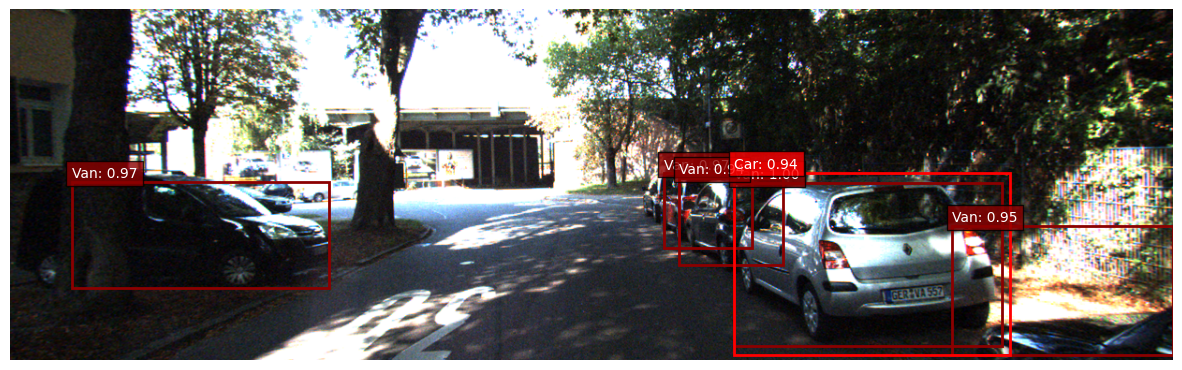


Accurate Detection Summary:
Van: 5 detected
Car: 1 detected


In [68]:
def advanced_nms(detections, class_names, iou_threshold=0.5, conf_threshold=0.4):
    """
    Advanced NMS that:
    1. Handles multi-class duplicates
    2. Resolves class conflicts
    3. Maintains spatial relationships
    """
    if len(detections) == 0:
        return []

    # Sort by confidence (descending)
    detections = sorted(detections, key=lambda x: -x[4])
    
    # Class grouping for conflict resolution
    vehicle_classes = ['Car', 'Van', 'Truck']
    class_groups = {
        'Car': 0,
        'Van': 0,
        'Truck': 0,
        'Pedestrian': 1,
    	'person_sitting': 1,
        'Cyclist': 2,
    	'Tram': 3, 
    	'Misc': 4,
    	'DontCare': 5
    }
    
    final_detections = []
    while detections:
        current = detections.pop(0)
        current_class = class_names[int(current[5])]
        
        # Check if current detection is better than existing ones
        keep = True
        for i, existing in enumerate(final_detections):
            existing_class = class_names[int(existing[5])]
            
            # Calculate IoU
            iou = calculate_iou(current[:4], existing[:4])
            
            # Same object if IoU > threshold and same class group
            if iou > iou_threshold and class_groups.get(current_class, -1) == class_groups.get(existing_class, -2):
                # Keep the detection with higher confidence
                if current[4] > existing[4]:
                    final_detections[i] = current
                keep = False
                break
                
        if keep:
            final_detections.append(current)
    
    return final_detections

def calculate_iou(box1, box2):
    """Improved IoU calculation with safety checks"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union_area = box1_area + box2_area - inter_area
    return inter_area / (union_area + 1e-6)  # Avoid division by zero

def visualize_detections(image, detections, class_names):
    """Enhanced visualization with class-specific styling"""
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(image)
    
    # Style configuration
    styles = {
        'Car': {'color': 'red', 'linewidth': 2},
        'Van': {'color': 'blue', 'linewidth': 2},
        'Truck': {'color': 'green', 'linewidth': 2},
        'Pedestrian': {'color': 'yellow', 'linewidth': 1.5},
        'Cyclist': {'color': 'cyan', 'linewidth': 1.5}
    }
    
    for det in detections:
        x1, y1, x2, y2, conf, cls = det
        class_name = class_names[int(cls)]
        style = styles.get(class_name, {'color': 'white', 'linewidth': 1})
        
        # Draw bounding box
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=style['linewidth'],
            edgecolor=style['color'],
            facecolor='none'
        )
        ax.add_patch(rect)
        
        # Label with confidence
        label = f"{class_name} {conf:.2f}"
        ax.text(x1, y1-5, label, 
               color='white',
               bbox=dict(facecolor=style['color'], alpha=0.8))
    
    plt.axis('off')
    plt.show()

def detect_vehicles(image_path, model, class_names):
    """Final vehicle detection with conflict resolution"""
    # Run base detection
    raw_detections = detect_objects(image_path, model, class_names, threshold=0.3)
    
    # Apply advanced NMS
    final_detections = advanced_nms(raw_detections, class_names)
    
    # Visualize
    image = Image.open(image_path).convert("RGB")
    visualize_detections(image, final_detections, class_names)
    
    # Print accurate counts
    counts = {name: 0 for name in class_names}
    for det in final_detections:
        counts[class_names[int(det[5])]] += 1
    
    print("\nAccurate Vehicle Count:")
    for class_name, count in counts.items():
        if count > 0:
            print(f"{class_name}: {count}")
    
    return final_detections

# Main execution
if __name__ == "__main__":
    # Class names must match training order
    class_names = ['Car', 'Van', 'Truck', 'Pedestrian', 
                  'Person_sitting', 'Cyclist', 'Tram', 
                  'Misc', 'DontCare']
    
    # Load models
    hybrid_model = load_hybrid_model(
        "trained_yolov10.pt",
        "trained_faster_rcnn.pth",
        FasterRCNNScratch
    )
    
    # Test image
    test_image_path = "/kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/000005.png"
    
    # Run refined detection
    detections = refined_detection(
        test_image_path,
        hybrid_model,
        class_names,
        threshold=0.93,  # Slightly higher confidence threshold
        iou_thresh=0.7  # Slightly stricter IoU threshold
    )


image 1/1 /kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/000002.png: 224x640 8 Cars, 10.6ms
Speed: 1.2ms preprocess, 10.6ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)

Detection Summary:
Van: 19
Truck: 1


YOLOv10 model loaded successfully.
Faster R-CNN model loaded successfully.

image 1/1 /kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/000034.png: 224x640 1 Car, 10.7ms
Speed: 1.2ms preprocess, 10.7ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)


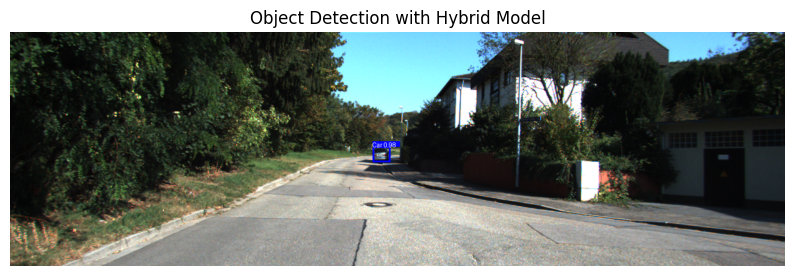


Generating SHAP explanations for all detections...
Processing detection 1/1: Car
SHAP values computed successfully for Car.
SHAP values shape: (1, 375, 1242, 3, 1)


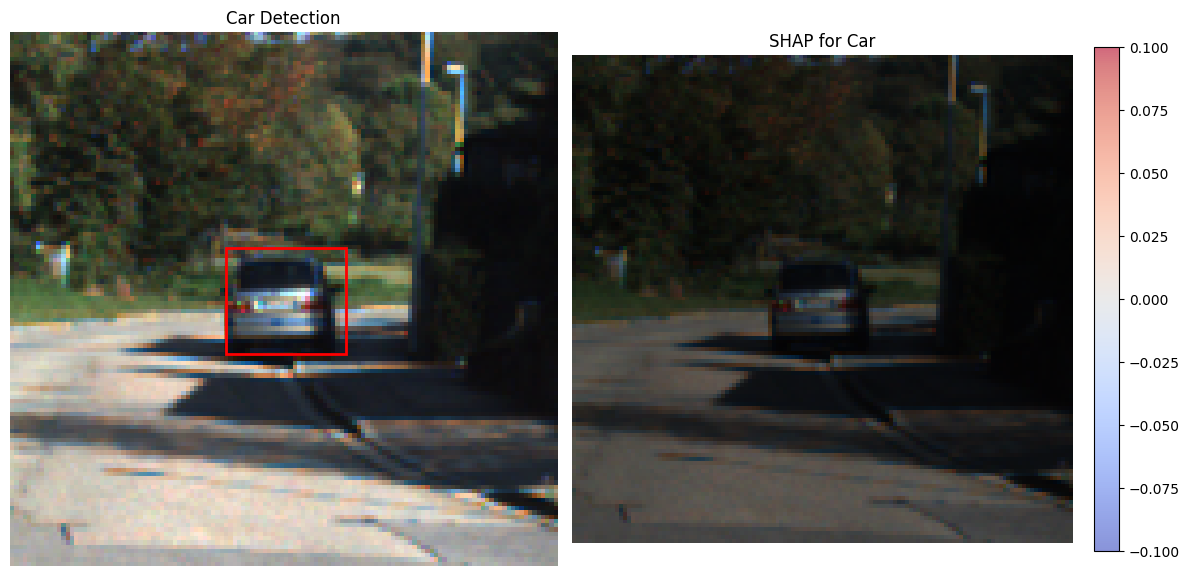

Detected 1 objects.
Object detection completed successfully.


In [6]:
import cv2
import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from torchvision.models.detection.roi_heads import RoIHeads
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, TwoMLPHead
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.ops import MultiScaleRoIAlign
from ultralytics import YOLO
from collections import defaultdict
import shap
import torchvision.transforms as T
from torchvision.models.resnet import ResNet50_Weights

# Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
YOLO_MODEL_PATH = '/kaggle/input/pedestrian-models/pytorch/default/1/trained_yolov10.pt'
FRCNN_MODEL_PATH = '/kaggle/input/pedestrian-models/pytorch/default/1/trained_faster_rcnn.pth'
CLASS_NAMES_DET = ['Van', 'Car', 'Pedestrian', 'Truck', 'Tram', 
                   'Cyclist', 'Person_sitting', 'Misc', 'DontCare']

# Custom Faster R-CNN Model
class FasterRCNNScratch(torch.nn.Module):
    def __init__(self, num_classes):
        super(FasterRCNNScratch, self).__init__()
        self.backbone = resnet_fpn_backbone('resnet50', weights=ResNet50_Weights.IMAGENET1K_V1, trainable_layers=3)
        out_channels = self.backbone.out_channels
        anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
        aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
        rpn_anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)
        rpn_head = RPNHead(out_channels, rpn_anchor_generator.num_anchors_per_location()[0])
        rpn_pre_nms_top_n = dict(training=2000, testing=1000)
        rpn_post_nms_top_n = dict(training=2000, testing=1000)
        self.rpn = RegionProposalNetwork(
            rpn_anchor_generator, rpn_head, 0.7, 0.3, 256, 0.5,
            rpn_pre_nms_top_n, rpn_post_nms_top_n, 0.7
        )
        box_roi_pool = MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=7, sampling_ratio=2)
        resolution = box_roi_pool.output_size[0]
        representation_size = 1024
        box_head = TwoMLPHead(out_channels * resolution ** 2, representation_size)
        box_predictor = FastRCNNPredictor(representation_size, num_classes)
        self.roi_heads = RoIHeads(
            box_roi_pool, box_head, box_predictor, 0.6, 0.4, 512, 0.25, None, 0.5, 0.3, 50
        )
        self.transform = GeneralizedRCNNTransform(800, 1333, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
    def forward(self, images, targets=None):
        if self.training and targets is None:
            raise ValueError("In training mode, targets should be passed")
        original_image_sizes = [img.shape[-2:] for img in images]
        images, targets = self.transform(images, targets)
        features = self.backbone(images.tensors)
        proposals, proposal_losses = self.rpn(images, features, targets)
        detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets)
        detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)
        return detections

# Load Hybrid Model
def load_hybrid_model(yolo_model_path, frcnn_model_path, frcnn_model_class):
    try:
        yolo_model = YOLO(yolo_model_path)
        print("YOLOv10 model loaded successfully.")
        frcnn_model = frcnn_model_class(num_classes=len(CLASS_NAMES_DET))
        frcnn_model.load_state_dict(torch.load(frcnn_model_path, map_location=DEVICE))
        frcnn_model.eval()
        frcnn_model.to(DEVICE)
        print("Faster R-CNN model loaded successfully.")
        return {'yolo': yolo_model, 'frcnn': frcnn_model}
    except Exception as e:
        print(f"Error loading hybrid model: {e}")
        return None

# Calculate IoU
def calculate_iou(box1, box2):
    x1 = max(float(box1[0]), float(box2[0]))
    y1 = max(float(box1[1]), float(box2[1]))
    x2 = min(float(box1[2]), float(box2[2]))
    y2 = min(float(box1[3]), float(box2[3]))
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (float(box1[2]) - float(box1[0])) * (float(box1[3]) - float(box1[1]))
    box2_area = (float(box2[2]) - float(box2[0])) * (float(box2[3]) - float(box2[1]))
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0.0

# Improved NMS
def improved_nms(detections, iou_threshold=0.5, class_merge_threshold=0.7):
    if not detections or len(detections) == 0:
        return []
    detections = [list(map(float, d)) for d in detections]
    detections = sorted(detections, key=lambda x: -x[4])
    keep = []
    while detections:
        current = detections.pop(0)
        keep.append(current)
        detections = [
            det for det in detections
            if not (calculate_iou(current[:4], det[:4]) > iou_threshold and 
                    (int(current[5]) == int(det[5]) or abs(current[4] - det[4]) < class_merge_threshold))
        ]
    return keep

# Refined Detection
def refined_detection(image_path, model, class_names, threshold=0.3, iou_thresh=0.5):
    try:
        image = Image.open(image_path).convert("RGB")
        yolo_results = model['yolo'](image_path)
        yolo_detections = yolo_results[0].boxes.data.cpu().numpy()
        transform = transforms.Compose([transforms.ToTensor()])
        image_tensor = transform(image).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            frcnn_outputs = model['frcnn'](image_tensor)
        frcnn_detections = []
        for det in frcnn_outputs:
            boxes = det['boxes'].cpu().numpy()
            scores = det['scores'].cpu().numpy()
            labels = det['labels'].cpu().numpy() - 1
            for box, score, label in zip(boxes, scores, labels):
                if 0 <= label < len(class_names) and score >= threshold:
                    frcnn_detections.append([*box, score, label])
        all_detections = []
        if len(yolo_detections) > 0:
            all_detections.extend(yolo_detections)
        if len(frcnn_detections) > 0:
            all_detections.extend(frcnn_detections)
        if not all_detections:
            print("No objects detected.")
            return np.array([]), image
        final_detections = improved_nms(all_detections, iou_thresh)
        car_van_detections = [d for d in final_detections if class_names[int(d[5])] in ['Car', 'Van']]
        other_detections = [d for d in final_detections if class_names[int(d[5])] not in ['Car', 'Van']]
        car_van_groups = defaultdict(list)
        for det in car_van_detections:
            box_id = f"{int(det[0])}_{int(det[1])}_{int(det[2])}_{int(det[3])}"
            car_van_groups[box_id].append(det)
        resolved_detections = [max(dets, key=lambda x: x[4]) for dets in car_van_groups.values()]
        final_detections = other_detections + resolved_detections
        return np.array(final_detections), image
    except Exception as e:
        print(f"Error in refined_detection: {e}")
        return np.array([]), None

# Draw Detections
def draw_detections(image, detections, class_names):
    image_with_boxes = image.copy()
    draw = ImageDraw.Draw(image_with_boxes)
    try:
        font = ImageFont.truetype("arial.ttf", 15)
    except:
        font = ImageFont.load_default()
    for det in detections:
        x1, y1, x2, y2, conf, cls = det
        label_name = class_names[int(cls)]
        color = "red" if label_name.lower() == "pedestrian" else "blue"
        draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
        text = f"{label_name} {conf:.2f}"
        text_bbox = font.getbbox(text)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
        draw.rectangle([x1, y1 - text_height, x1 + text_width + 5, y1], fill=color)
        draw.text((x1, y1 - text_height), text, fill="white", font=font)
    return image_with_boxes

# SHAP Explainer Class
class ShapExplainer:
    def __init__(self, model, class_names, target_class):
        self.model = model
        self.class_names = class_names
        self.target_class = target_class
        self.target_index = class_names.index(target_class)
        self.transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def predict(self, imgs):
        if isinstance(imgs, np.ndarray):
            if imgs.ndim == 3:
                imgs = [Image.fromarray(imgs)]
            else:
                imgs = [Image.fromarray(img) for img in imgs]
        inputs = torch.stack([self.transform(img) for img in imgs]).to(next(self.model.parameters()).device)
        with torch.no_grad():
            outputs = self.model(inputs)
        scores = []
        for output in outputs:
            target_scores = [score.item() for box, score, label in zip(output['boxes'], output['scores'], output['labels'])
                             if label - 1 == self.target_index]
            scores.append(max(target_scores) if target_scores else 0)
        return np.array(scores).reshape(-1, 1)
    
    def explain(self, image_path, n_samples=50):
        img = Image.open(image_path).convert("RGB")
        img_np = np.array(img)
        masker = shap.maskers.Image("blur(128,128)", img_np.shape)
        explainer = shap.Explainer(self.predict, masker, output_names=[self.target_class])
        try:
            shap_values = explainer(
                np.expand_dims(img_np, 0),
                max_evals=n_samples,
                batch_size=8,
                outputs=shap.Explanation.argsort.flip[:1]
            )
            print(f"SHAP values computed successfully for {self.target_class}.")
            return img_np, shap_values
        except Exception as e:
            print(f"SHAP explanation failed for {self.target_class}: {e}")
            return img_np, None

# Crop Image and Heatmap Around Detection
def crop_around_box(image, box, padding=50):
    x1, y1, x2, y2 = map(int, box)
    h, w = image.shape[:2]
    x1 = max(0, x1 - padding)
    y1 = max(0, y1 - padding)
    x2 = min(w, x2 + padding)
    y2 = min(h, y2 + padding)
    return image[y1:y2, x1:x2], (x1, y1, x2, y2)

# Plot SHAP Explanations with Subplots
def plot_shap_explanations_all(image, detections, shap_values_list, class_names):
    num_detections = len(detections)
    if num_detections == 0:
        return
    
    fig, axes = plt.subplots(num_detections, 2, figsize=(12, 6 * num_detections))
    if num_detections == 1:
        axes = [axes]  # Ensure axes is iterable for single detection
    
    for i, (detection, shap_values) in enumerate(zip(detections, shap_values_list)):
        target_class = class_names[int(detection[5])]
        box = detection[:4]
        
        # Crop image and adjust box coordinates
        cropped_img, (x1, y1, x2, y2) = crop_around_box(image, box)
        if shap_values is not None and hasattr(shap_values, 'values') and len(shap_values.values) > 0:
            shap_vals = shap_values.values[0]
            heatmap = np.sum(shap_vals, axis=-1)
            cropped_heatmap, _ = crop_around_box(heatmap, box)
            max_val = np.max(np.abs(shap_vals))
        else:
            cropped_heatmap = None
        
        # Plot cropped original image
        ax_img = axes[i][0] if num_detections > 1 else axes[0][0]
        ax_img.imshow(cropped_img)
        rect = patches.Rectangle((int(box[0]) - x1, int(box[1]) - y1), 
                                 int(box[2] - box[0]), int(box[3] - box[1]), 
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax_img.add_patch(rect)
        ax_img.set_title(f"{target_class} Detection")
        ax_img.axis('off')
        
        # Plot cropped SHAP heatmap
        ax_shap = axes[i][1] if num_detections > 1 else axes[0][1]
        ax_shap.imshow(cropped_img)
        if cropped_heatmap is not None:
            im = ax_shap.imshow(cropped_heatmap, cmap='coolwarm', alpha=0.6, vmin=-max_val, vmax=max_val)
            plt.colorbar(im, ax=ax_shap, fraction=0.046, pad=0.04)
            ax_shap.set_title(f"SHAP for {target_class}")
        else:
            ax_shap.text(0.5, 0.5, "No SHAP values", ha='center', va='center', transform=ax_shap.transAxes)
            ax_shap.set_title(f"SHAP Failed for {target_class}")
        ax_shap.axis('off')
    
    plt.tight_layout()
    plt.show()

# Process Image with SHAP for All Detections
def process_image(image_path, det_model, threshold=0.3, explain=True):
    try:
        # Object Detection
        final_detections, original_image = refined_detection(image_path, det_model, CLASS_NAMES_DET, threshold)
        if len(final_detections) == 0:
            print("No objects detected.")
            plt.figure(figsize=(10, 10))
            plt.imshow(original_image)
            plt.title('Object Detection (No Objects)')
            plt.axis('off')
            plt.show()
            return original_image, final_detections
        
        # Draw detections
        image_with_boxes = draw_detections(original_image, final_detections, CLASS_NAMES_DET)
        
        # Visualization of Detection
        plt.figure(figsize=(10, 10))
        plt.imshow(image_with_boxes)
        plt.title('Object Detection with Hybrid Model')
        plt.axis('off')
        plt.show()
        
        # SHAP Explanation for All Detections
        if explain and len(final_detections) > 0:
            print("\nGenerating SHAP explanations for all detections...")
            shap_values_list = []
            for i, detection in enumerate(final_detections):
                target_class = CLASS_NAMES_DET[int(detection[5])]
                print(f"Processing detection {i+1}/{len(final_detections)}: {target_class}")
                explainer = ShapExplainer(det_model['frcnn'], CLASS_NAMES_DET, target_class=target_class)
                img_np, shap_values = explainer.explain(image_path, n_samples=50)
                shap_values_list.append(shap_values)
                if shap_values is not None:
                    print("SHAP values shape:", shap_values.values.shape)
                else:
                    print(f"Failed to generate SHAP values for {target_class}.")
            
            # Plot all SHAP explanations in subplots
            plot_shap_explanations_all(np.array(original_image), final_detections, shap_values_list, CLASS_NAMES_DET)
        else:
            print("No objects detected; skipping SHAP explanation.")
        
        print(f"Detected {len(final_detections)} objects.")
        return image_with_boxes, final_detections
    
    except Exception as e:
        print(f"Error in process_image: {e}")
        return None, []

# Main Execution
if __name__ == "__main__":
    hybrid_model = load_hybrid_model(YOLO_MODEL_PATH, FRCNN_MODEL_PATH, FasterRCNNScratch)
    if hybrid_model is None:
        print("Failed to load hybrid model. Exiting.")
        exit(1)
    
    image_path = "/kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/000034.png"  # Replace with your image path
    result_image, object_detections = process_image(image_path, hybrid_model, threshold=0.3, explain=True)
    
    if result_image is not None:
        print("Object detection completed successfully.")
    else:
        print("Object detection failed.")

YOLOv10 model loaded successfully.
Faster R-CNN model loaded successfully.

image 1/1 /kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/000018.png: 224x640 10 Cars, 10.2ms
Speed: 1.2ms preprocess, 10.2ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)


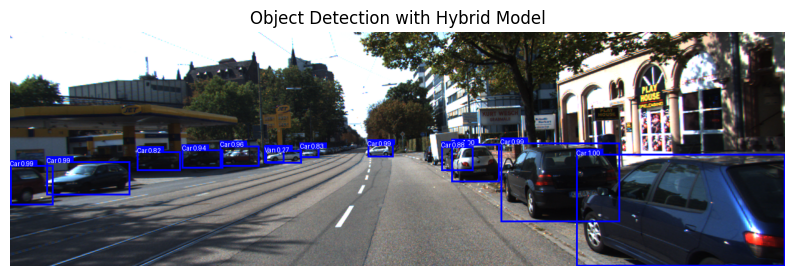


Generating SHAP explanations for all detections...
Processing detection 1/13: Car
SHAP values computed successfully for Car.
SHAP values shape: (1, 375, 1242, 3, 1)
Processing detection 2/13: Car
SHAP values computed successfully for Car.
SHAP values shape: (1, 375, 1242, 3, 1)
Processing detection 3/13: Car
SHAP values computed successfully for Car.
SHAP values shape: (1, 375, 1242, 3, 1)
Processing detection 4/13: Car
SHAP values computed successfully for Car.
SHAP values shape: (1, 375, 1242, 3, 1)
Processing detection 5/13: Car
SHAP values computed successfully for Car.
SHAP values shape: (1, 375, 1242, 3, 1)
Processing detection 6/13: Car
SHAP values computed successfully for Car.
SHAP values shape: (1, 375, 1242, 3, 1)
Processing detection 7/13: Car
SHAP values computed successfully for Car.
SHAP values shape: (1, 375, 1242, 3, 1)
Processing detection 8/13: Car
SHAP values computed successfully for Car.
SHAP values shape: (1, 375, 1242, 3, 1)
Processing detection 9/13: Car
SHAP 

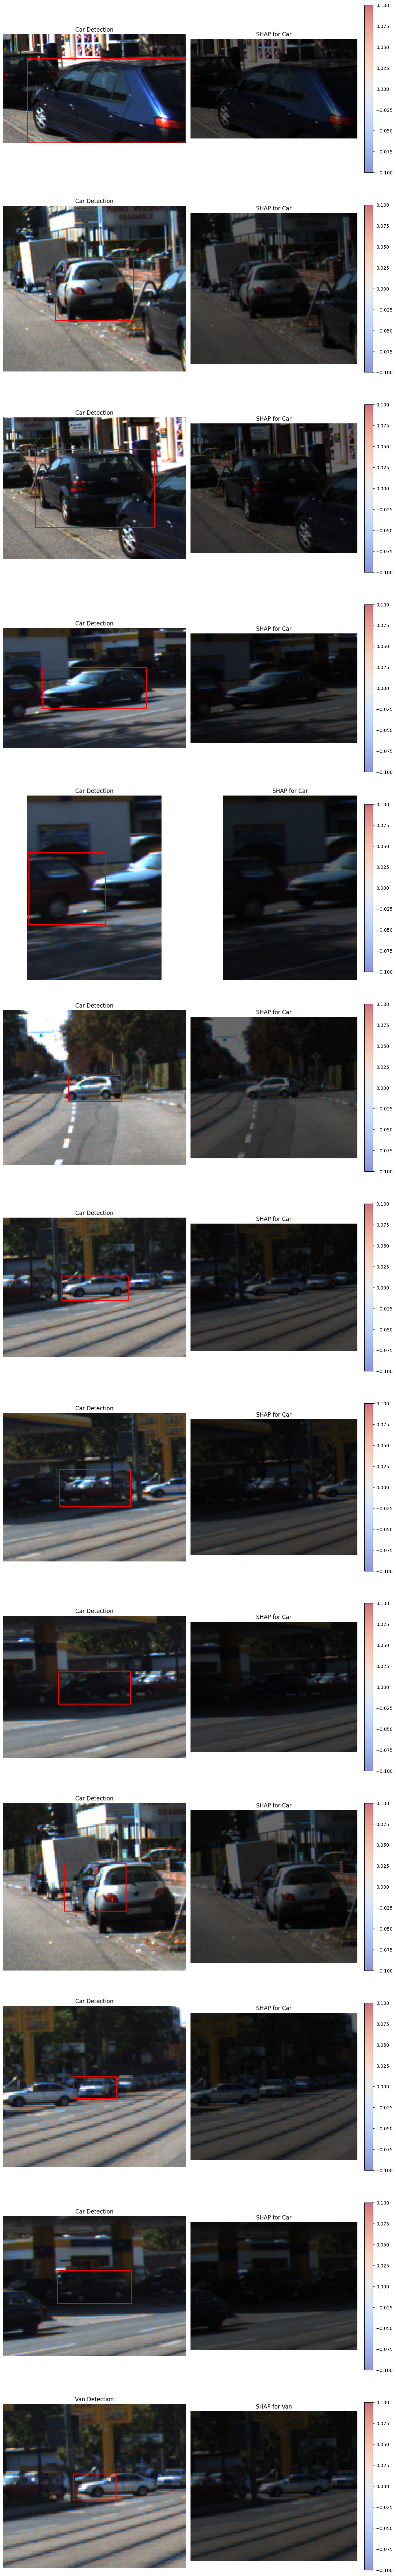

Detected 13 objects.
Object detection completed successfully.


In [8]:
hybrid_model = load_hybrid_model(YOLO_MODEL_PATH, FRCNN_MODEL_PATH, FasterRCNNScratch)
if hybrid_model is None:
    print("Failed to load hybrid model. Exiting.")
    exit(1)

image_path = "/kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/000018.png"  # Replace with your image path
result_image, object_detections = process_image(image_path, hybrid_model, threshold=0.3, explain=True)

if result_image is not None:
    print("Object detection completed successfully.")
else:
    print("Object detection failed.")

YOLOv10 model loaded successfully.
Faster R-CNN model loaded successfully.

image 1/1 /kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/000042.png: 224x640 2 Cars, 10.9ms
Speed: 1.3ms preprocess, 10.9ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)


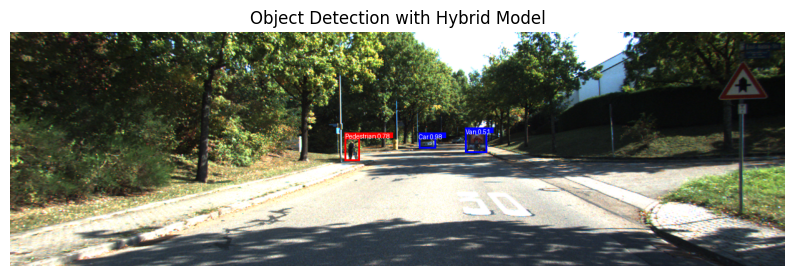


Generating SHAP explanations for all detections...
Processing detection 1/3: Pedestrian
SHAP values computed successfully for Pedestrian.
SHAP values shape: (1, 375, 1242, 3, 1)
Processing detection 2/3: Car
SHAP values computed successfully for Car.
SHAP values shape: (1, 375, 1242, 3, 1)
Processing detection 3/3: Van
SHAP values computed successfully for Van.
SHAP values shape: (1, 375, 1242, 3, 1)


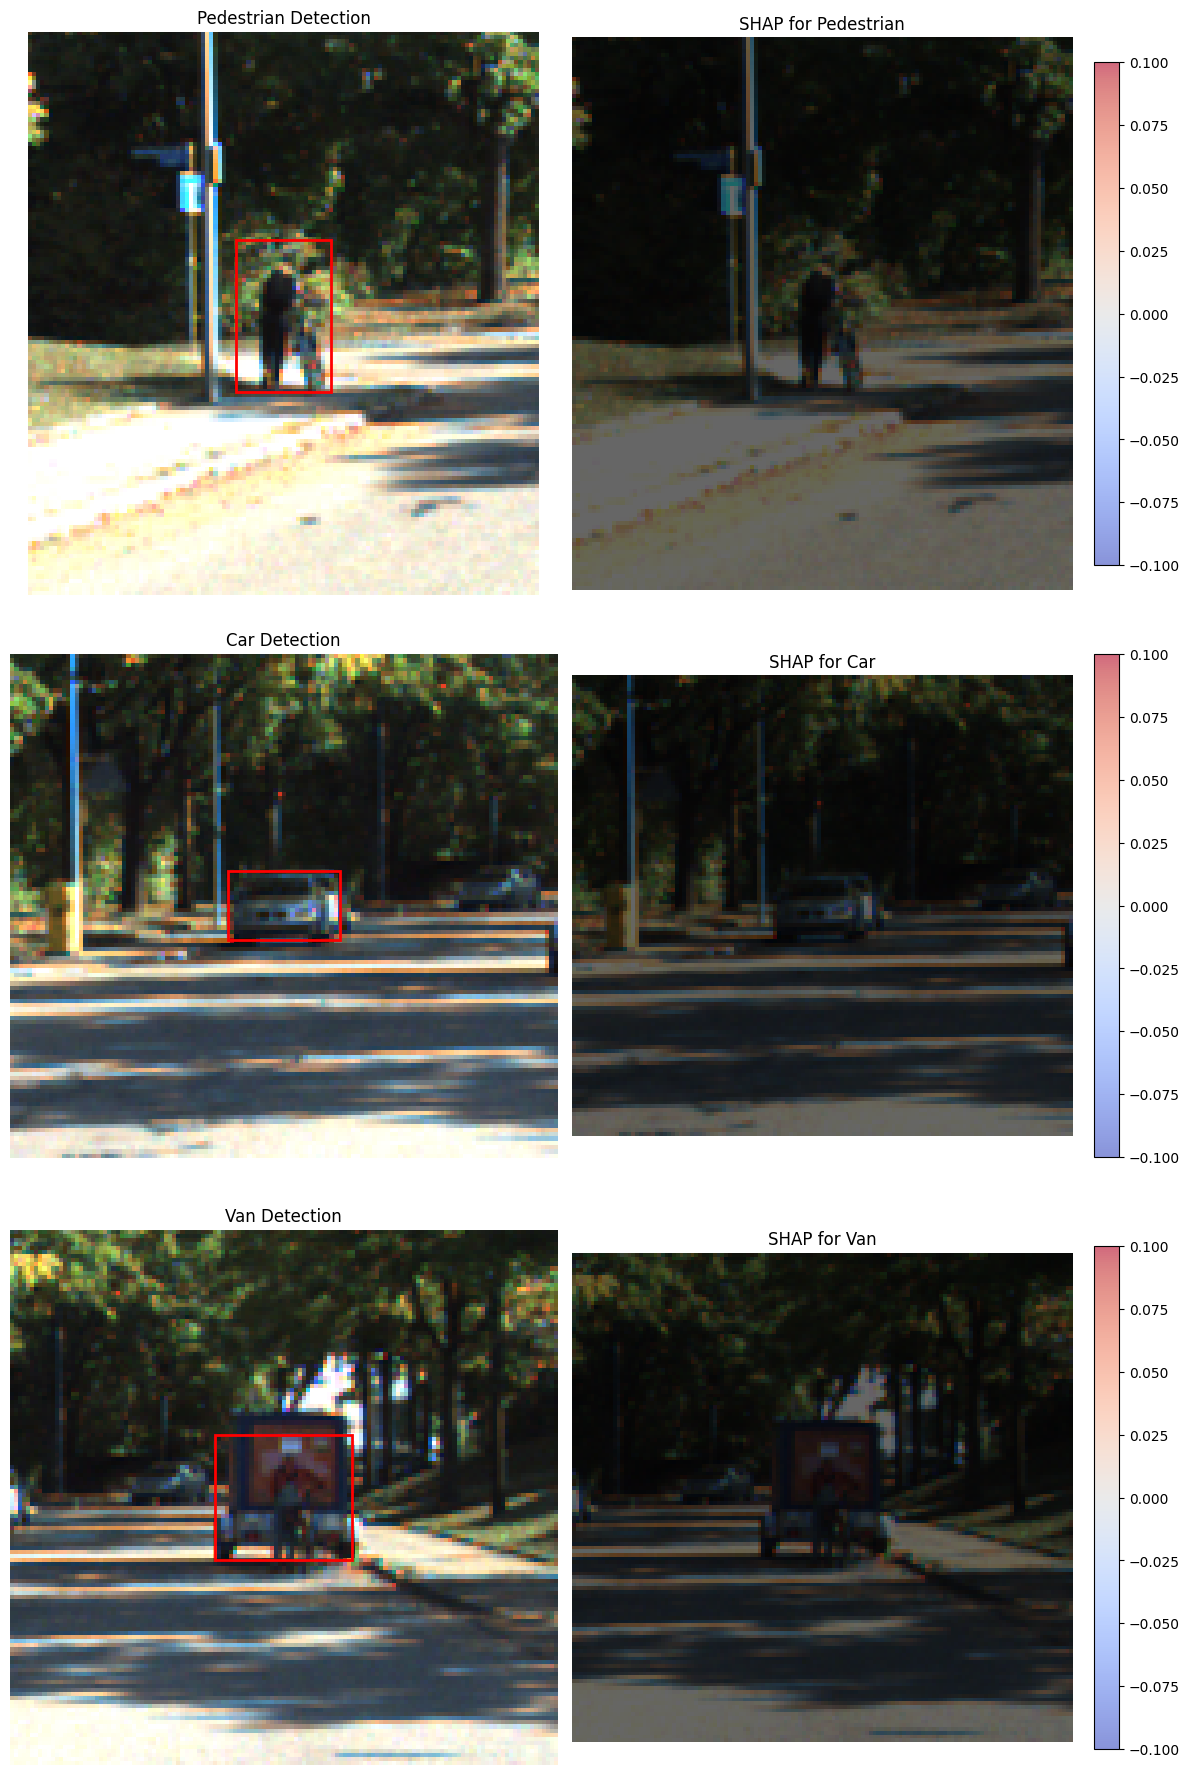

Detected 3 objects.
Object detection completed successfully.


In [9]:
hybrid_model = load_hybrid_model(YOLO_MODEL_PATH, FRCNN_MODEL_PATH, FasterRCNNScratch)
if hybrid_model is None:
    print("Failed to load hybrid model. Exiting.")
    exit(1)

image_path = "/kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/000042.png"  # Replace with your image path
result_image, object_detections = process_image(image_path, hybrid_model, threshold=0.3, explain=True)

if result_image is not None:
    print("Object detection completed successfully.")
else:
    print("Object detection failed.")